# Get the Exact Answer
Start off by computing the exact Hessian to use a reference point. 
First relax the structure then compute the Hessians using [ase's Vibrations module](https://databases.fysik.dtu.dk/ase/ase/vibrations/modes.html), which will compute them numerically using central derivatives

In [1]:
from ase.thermochemistry import IdealGasThermo
from ase.vibrations import VibrationsData, Vibrations
from ase import Atoms, units
from ase.io import write
from time import perf_counter
from platform import node
from pathlib import Path
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import shutil
import json
import os

## Configure

In [2]:
molecule_name = 'water'
deltas = [.0005, .001, 0.005, 0.008, 0.01, 0.012, 0.02, 0.05, .1, .2]
deltas = [0.0005, 0.002, 0.005, 0.008, 0.01, 0.012, 0.02, 0.05]
levels = [['hf', 'def2-svpd'],['hf','6-31g*'],['b3lyp','6-31g*'],['b3lyp','cc-pvtz'],['m062x', 'cc-pvtz'],['wb97x-d','cc-pvtz'],['ccsd(t)','cc-pvdz']]
threads = min(os.cpu_count(), 12)
prefix = '/home/elliott/Packages/faster-molecular-hessians/notebooks'

## Load in Target Hessians
We have it in a JSON file from PubChem

In [3]:
def load_hessian(name: str) -> VibrationsData:
    """Load a molecule from a PubChem JSON file
    
    Args:
        name: Name of the molecule
    Returns:
        ASE Atoms object
    """
    
    # Get the compound data
    with open(f'{prefix}/data/exact/{name}.json') as fp:
         exact_vibs = VibrationsData.read(fp)
        
    # Build the object    
    return exact_vibs

In [4]:
hess_dct = {}
analy_dct = {}
for level in levels:
    method, basis = level
    level = '/'.join(level)
    analy_dct[level] = load_hessian(f'{molecule_name}_{method}_{basis}-analytic')
    if not level in hess_dct:
        hess_dct[level] = {}
    for delta in deltas:
        run_name = f'{molecule_name}_{method}_{basis}-{delta}-ase'
        hess_dct[level][delta] = load_hessian(run_name)

In [5]:
analy_data = load_hessian(f'{molecule_name}_ccsd(t)_cc-pvtz-analytic')

## Load in Target Molecule
We have it in a JSON file from PubChem

In [6]:
def load_molecule(name: str) -> Atoms:
    """Load a molecule from a PubChem JSON file
    
    Args:
        name: Name of the molecule
    Returns:
        ASE Atoms object
    """
    
    # Get the compound data
    with open(f'../data/structures/{name}.json') as fp:
        data = json.load(fp)
    data = data['PC_Compounds'][0]
        
    # Extract data from the JSON
    atomic_numbers = data['atoms']['element']
    positions = np.zeros((len(atomic_numbers), 3))
    conf_data = data['coords'][0]['conformers'][0]
    for i, c in enumerate('xyz'):
        if c in conf_data:
            positions[:, i] = conf_data[c]
        
    # Build the object    
    return Atoms(numbers=atomic_numbers, positions=positions)

In [7]:
atoms = load_molecule(molecule_name)

In [8]:
for level in hess_dct:
    vib_data = analy_dct[level]
    print(level, 'analytical', vib_data.get_zero_point_energy())
    for delta in hess_dct[level]:
        vib_data = hess_dct[level][delta]
        print(level, delta, vib_data.get_zero_point_energy())

hf/def2-svpd analytical 1.5413228180170395
hf/def2-svpd 0.0005 0.6274792164111337
hf/def2-svpd 0.002 0.6274838677813996
hf/def2-svpd 0.005 0.6281157945216034
hf/def2-svpd 0.008 0.6295946433753703
hf/def2-svpd 0.01 0.6306709851090709
hf/def2-svpd 0.012 0.6315984933086431
hf/def2-svpd 0.02 0.6349526183383649
hf/def2-svpd 0.05 0.6465761771229199
hf/6-31g* analytical 1.5359654224080965
hf/6-31g* 0.0005 0.6251883098619834
hf/6-31g* 0.002 0.6255554248646287
hf/6-31g* 0.005 0.6269689453875052
hf/6-31g* 0.008 0.6281747108454533
hf/6-31g* 0.01 0.6289579590001761
hf/6-31g* 0.012 0.6297345294629221
hf/6-31g* 0.02 0.6328091930148836
hf/6-31g* 0.05 0.6441143599770296
b3lyp/6-31g* analytical 1.5307967589994456
b3lyp/6-31g* 0.0005 0.5778774473072096
b3lyp/6-31g* 0.002 0.5778874190031266
b3lyp/6-31g* 0.005 0.5780467022950675
b3lyp/6-31g* 0.008 0.5783083792125614
b3lyp/6-31g* 0.01 0.5785254648854226
b3lyp/6-31g* 0.012 0.5788018668977699
b3lyp/6-31g* 0.02 0.5820393193072373
b3lyp/6-31g* 0.05 0.592650817

In [9]:
analy_freqs = analy_data.get_frequencies()
non_vib_modes = analy_freqs[:6]
print('convergence', sum(non_vib_modes))
analy_vibs = analy_freqs[6:]
analy_zpve = analy_data.get_zero_point_energy()
y_labels = []
all_abs_errors = []
all_abs_errors_from_self = []
all_real_conv = []
all_imag_conv = []
all_zpve_errors = []
print(analy_zpve * 23.06)

for level in hess_dct:
    x_labels = []
    abs_errors = []
    abs_errors_from_self = []
    zpve_errors = []
    real_conv = []
    imag_conv = []
    vib_data = analy_dct[level]
    lvl_analy_freqs = vib_data.get_frequencies()
    lvl_analy_zpve = vib_data.get_zero_point_energy()
    for delta in hess_dct[level]:
        vib_data = hess_dct[level][delta]
        print('\nlevel:', level, 'step:', delta)
        numer_freqs = vib_data.get_frequencies()
        print('convergence', sum(numer_freqs[:6]))
        print(f'zpve error {(vib_data.get_zero_point_energy() - analy_zpve) * 23.06:.2f} kcal/mol, {(vib_data.get_zero_point_energy()) * 23.06:.2f}')
        numer_freqs = vib_data.get_frequencies()
        abs_freq_diffs = [abs(freq.real - analy_freq.real) for freq, analy_freq in zip(numer_freqs[6:], analy_vibs)]
        rel_freq_diffs = [abs(freq.real - analy_freq.real)/(analy_freq.real) for freq, analy_freq in zip(numer_freqs[6:], analy_vibs)]
        print(f'absolute frequency error {sum(abs_freq_diffs):.2f} cm-1')
        print(f'relative frequency error {sum(rel_freq_diffs):.2f}%')
        self_freq_diffs = [abs(freq.real - lvl_analy_freq.real) for freq, lvl_analy_freq in zip(numer_freqs[6:], lvl_analy_freqs[6:])]
        real_conv.append(sum(freq.real for freq in numer_freqs[:6]))
        imag_conv.append(sum(freq.imag for freq in numer_freqs[:6]))
        x_labels.append(f'{delta}')
        abs_errors.append(sum(abs_freq_diffs))
        abs_errors_from_self.append(sum(self_freq_diffs))
        zpve_errors.append(abs(vib_data.get_zero_point_energy() - analy_zpve) * 23.06)
    y_labels.append(level)
    all_abs_errors.append(abs_errors)
    all_abs_errors_from_self.append(abs_errors_from_self)
    all_real_conv.append(real_conv)
    all_imag_conv.append(imag_conv)
    all_zpve_errors.append(zpve_errors)

convergence (37.673513689629054+10.901340587933717j)
13.61826587346484

level: hf/def2-svpd step: 0.0005
convergence (0.0033962428828235697+51.032957474745224j)
zpve error 0.85 kcal/mol, 14.47
absolute frequency error 633.25 cm-1
relative frequency error 0.18%

level: hf/def2-svpd step: 0.002
convergence (0.08112684560629407+51.766938362133644j)
zpve error 0.85 kcal/mol, 14.47
absolute frequency error 633.25 cm-1
relative frequency error 0.18%

level: hf/def2-svpd step: 0.005
convergence (10.320308195665945+48.58099443505995j)
zpve error 0.87 kcal/mol, 14.48
absolute frequency error 633.20 cm-1
relative frequency error 0.18%

level: hf/def2-svpd step: 0.008
convergence (34.26023187997178+49.31635945261442j)
zpve error 0.90 kcal/mol, 14.52
absolute frequency error 633.12 cm-1
relative frequency error 0.18%

level: hf/def2-svpd step: 0.01
convergence (51.70092314815463+59.823242577218124j)
zpve error 0.93 kcal/mol, 14.54
absolute frequency error 633.04 cm-1
relative frequency error 0.18%

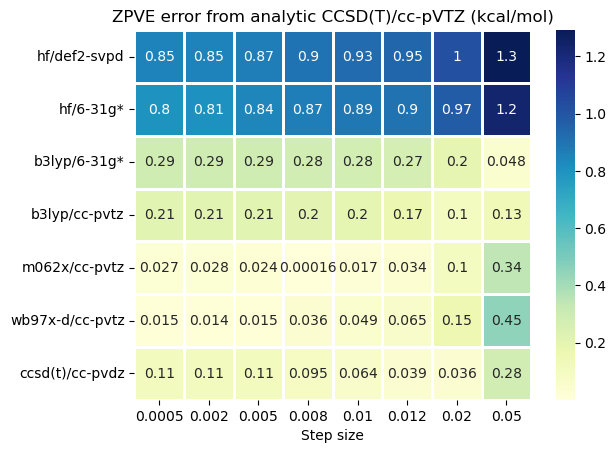

In [10]:
ax = sns.heatmap(all_zpve_errors, cmap="YlGnBu", linewidth=1, annot=True, xticklabels=x_labels, yticklabels=y_labels)
plt.title('ZPVE error from analytic CCSD(T)/cc-pVTZ (kcal/mol)')
plt.xlabel('Step size')
plt.show()

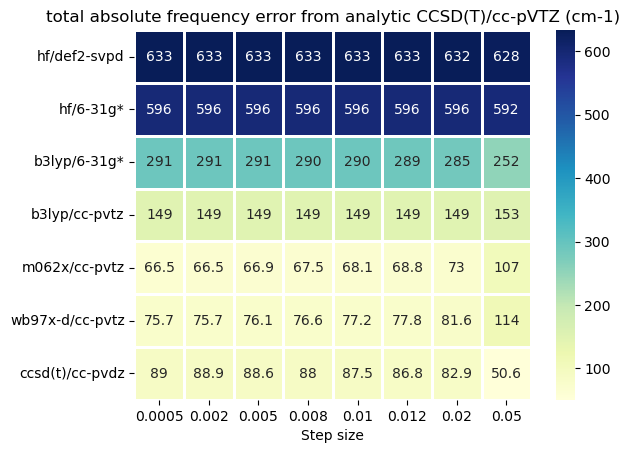

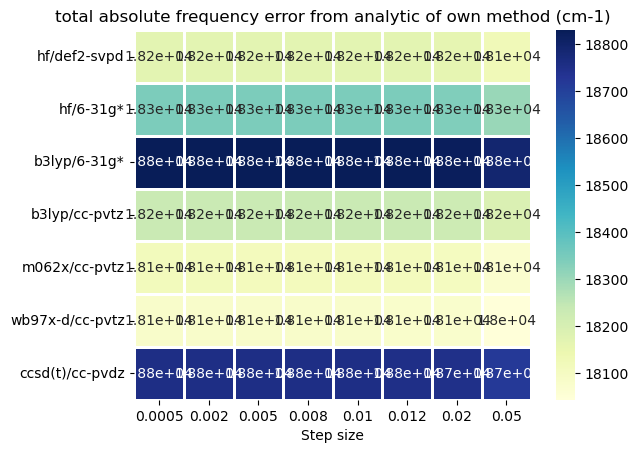

In [11]:
ax = sns.heatmap(all_abs_errors, cmap="YlGnBu", linewidth=1, annot=True, fmt='.3g', xticklabels=x_labels, yticklabels=y_labels)
plt.title('total absolute frequency error from analytic CCSD(T)/cc-pVTZ (cm-1)')
plt.xlabel('Step size')
plt.show()
ax = sns.heatmap(all_abs_errors_from_self, cmap="YlGnBu", linewidth=1, annot=True, fmt='.3g', xticklabels=x_labels, yticklabels=y_labels)
plt.title('total absolute frequency error from analytic of own method (cm-1)')
plt.xlabel('Step size')
plt.show()


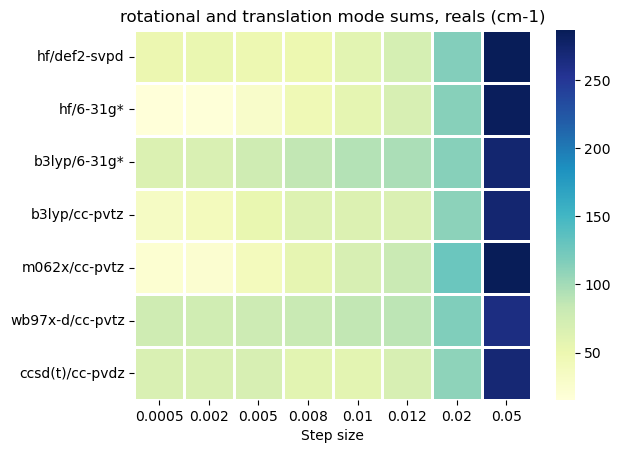

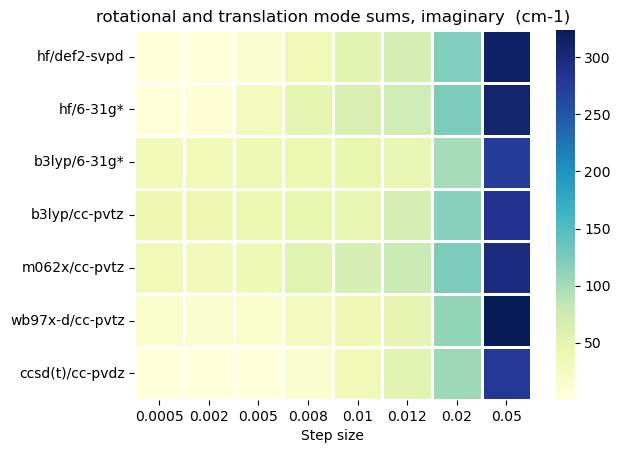

In [12]:
#fig, axs = plt.subplots(1, 1, figsize=(5,5))
axs = sns.heatmap(all_imag_conv, cmap="YlGnBu", linewidth=1,  xticklabels=x_labels, yticklabels=y_labels)
plt.title('rotational and translation mode sums, reals (cm-1)')
plt.xlabel('Step size')
plt.show()
axs = sns.heatmap(all_real_conv, cmap="YlGnBu", linewidth=1,  xticklabels=x_labels, yticklabels=y_labels)
plt.title('rotational and translation mode sums, imaginary  (cm-1)')
plt.xlabel('Step size')
plt.show()